In [66]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

from sklearn.metrics import mean_squared_error

import pickle
from collections import defaultdict
import json

from tqdm import tqdm 

import pandas as pd, numpy as np, matplotlib.pyplot as plt

import sys 
sys.path.insert(1, "../")
from workloads.util import use_results, use_dataset, read_config, log_dataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
dataset_dir = use_dataset("ml-latest-small")

/data/wooders/ralf-vldb//datasets/ml-latest-small


In [7]:
ratings_path = f"{dataset_dir}/ratings.csv"
tags_path = f"{dataset_dir}/tags.csv" 
movies_path = f"{dataset_dir}/movies.csv"

In [10]:
tags = pd.read_csv(tags_path)
tags.columns = ['user_id', 'movie_id', 'tag', 'timestamp']
ratings = pd.read_csv(ratings_path)
ratings.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
movies = pd.read_csv(movies_path)
movies.columns = ['movie_id', 'title', 'genres']

In [20]:
user_matrix = pickle.load(open(f"{dataset_dir}/trained_users.pkl", "rb"))
movie_matrix = pickle.load(open(f"{dataset_dir}/trained_items.pkl", "rb"))
movie_to_index = json.load(open(f"{dataset_dir}/movie_to_index.json", "r"))
user_to_index = json.load(open(f"{dataset_dir}/user_to_index.json", "r"))
A = pickle.load(open(f"{dataset_dir}/A.pkl", "rb"))
R = pickle.load(open(f"{dataset_dir}/R.pkl", "rb"))

test_df = pd.read_csv(f"{dataset_dir}/test.csv")

In [213]:
class UserEventQueue: 
    
    """
    Event queue that selects group of user updates
    (note: we can have another implementation which triggers a bunch of updates together)
    """
    
    def __init__(self, num_keys, policy): 
        self.total_error = np.zeros((num_keys))
        self.updates = defaultdict(list)
        self.policy = policy 
        self.num_keys = num_keys
        self.next_key = 0
        
    def push(self, uid, mid, rating): 
        
        # calcualte error 
        error = np.dot(movie_matrix[mi], streaming_user_matrix[ui]) - rating # need bias? 
        error = abs(error) #error*error # square 
        
        # update per key 
        self.total_error[uid] += error
        self.updates[uid].append((uid, mid, rating))
        
        
    def choose_key(self): 
        if self.policy == "total_error":
            return self.total_error.argmax()
        elif self.policy == "max_pending": 
            max_key = None
            max_len = -1 
            for key in self.updates.keys(): 
                if len(self.updates[key]) > max_len: 
                    max_len = len(self.updates[key])
                    max_key = key 
            assert max_key is not None
            return max_key 
        
        # round robin keys 
        self.next_key += 1
        while len(self.updates[self.next_key]) == 0: 
            self.next_key += 1
            if self.next_key >= self.num_keys: 
                self.next_key = 0
        return self.next_key
    
    def pop(self): 
        key = self.choose_key()
        #print(key, self.total_error[key])
        events = self.updates[key]
        self.updates[key] = []
        self.total_error[key] = 0
        return events 
        
        
    

In [106]:
data = {}

for ts in test_df.groupby("timestamp").groups.keys(): 
    data[ts] = test_df[test_df["timestamp"] == ts].to_dict("records")

In [160]:
def simulate(test_df, policy, runtime, limit=1000):

    y_true = []
    y_pred = []
    users = []
    movies = []
    staleness = [] 
    update_times = defaultdict(list)
    
    num_updates = 0
    
    next_update = 0

    streaming_user_matrix = np.array(user_matrix, copy=True) 
    A_matrix = np.array(A, copy=True)
    R_matrix = np.array(R, copy=True)

    q = UserEventQueue(test_df.user_id.max(), policy)
    #for index, row in test_df.iloc[:limit].iterrows():
    for ts in tqdm(list(data.keys())[:limit]): 

        # process events 
        for event in data[ts]: 

            ui = user_to_index[str(int(event["user_id"]))]
            mi = movie_to_index[str(int(event["movie_id"]))]

            # predict / evaluate 
            y_pred.append(np.dot(movie_matrix[mi], streaming_user_matrix[ui]))
            y_true.append(event["rating"])
            users.append(ui)
            movies.append(mi)
            

            # push event to queue 
            q.push(ui, mi, event["rating"])

        # run feature update 
        if ts >= next_update: 
            events = q.pop()
            for event in events: 
                ui = event[0]
                mi = event[1]
                rating = event[2]

                A_matrix[ui][mi] = row["rating"]
                R_matrix[ui][mi] = 1
                Ri = R_matrix[ui]
                user_features = user_matrix[ui]
                user_feature_reg = 10
                n_factors = len(user_features)

            # TODO: add multiple options for way to update here 
            # use sklearn ? 
            streaming_user_matrix[ui] = np.linalg.solve(
                np.dot(movie_matrix.T, np.dot(np.diag(Ri), movie_matrix)) + user_feature_reg * np.eye(n_factors),
                np.dot(movie_matrix.T, np.dot(np.diag(Ri), A_matrix[ui].T))
            ).T
            next_update = ts + runtime 
            num_updates += 1 
            update_times[ui].append(ts)
     
    update_df = pd.DataFrame([
        [policy, runtime, k, i, update_times[k][i]]
        for k, v in update_times.items() for i in range(len(v))
    ], columns = ["runtime", "policy", "key", "i", "time"])
    return update_df, pd.DataFrame({"y_true": y_true, "y_pred": y_pred, "user_id": users, "movie_id": movies})

In [161]:
rr_update_df, rr_df = simulate(test_df, "round_robin", runtime=1, limit=100) 

100%|██████████| 100/100 [00:12<00:00,  7.76it/s]


In [214]:
te_update_df, te_df = simulate(test_df, "total_error", runtime=1, limit=100)
mean_squared_error(te_df.y_pred, te_df.y_true)

100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


2.342040549872276

In [212]:
te_update_df, te_df = simulate(test_df, "total_error", runtime=1, limit=100)
mean_squared_error(te_df.y_pred, te_df.y_true)

100%|██████████| 100/100 [00:13<00:00,  7.51it/s]


2.3868562779379423

In [215]:
mp_update_df, mp_df = simulate(test_df, "max_pending", runtime=1, limit=100) 

100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


In [216]:
mean_squared_error(mp_df.y_pred, mp_df.y_true)

2.307553511360039

In [217]:
runtime = [4, 2, 1]
policy = ["round_robin", "total_error", "max_pending"]

results = []
updates_df = pd.DataFrame()
df_all = pd.DataFrame()

for r in runtime: 
    for p in policy: 
        update_df, df = simulate(test_df, p, r, limit=1000)
        
        error = mean_squared_error(df.y_pred, df.y_true)
        total_updates = len(update_df.index)
        results.append([r, p, error, total_updates])
        updates_df = pd.concat([updates_df, update_df])
        df_all = pd.concat([df_all, df])
        
results_df = pd.DataFrame(results, columns=["runtime", "policy", "error", "total_updates"])
results_df

100%|██████████| 1000/1000 [02:13<00:00,  7.47it/s]


,runtime,policy,error,total_updates
0,4,round_robin,3.012006,271
1,4,total_error,2.913453,271
2,4,max_pending,2.860849,271
3,2,round_robin,2.803559,520
4,2,total_error,2.754487,520
5,2,max_pending,2.712641,520
6,1,round_robin,2.685585,1000
7,1,total_error,2.650297,1000
8,1,max_pending,2.624418,1000


In [227]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(10,5)})

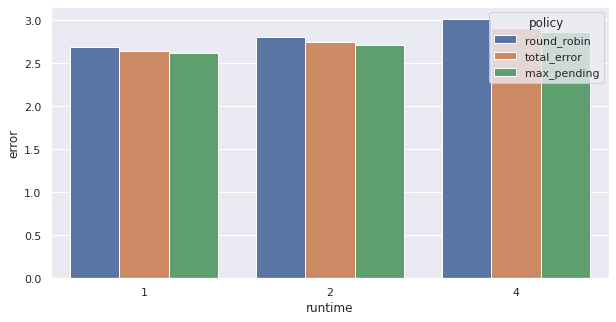

In [228]:
ax = sns.barplot(x="runtime", y="error", hue="policy", data=results_df)

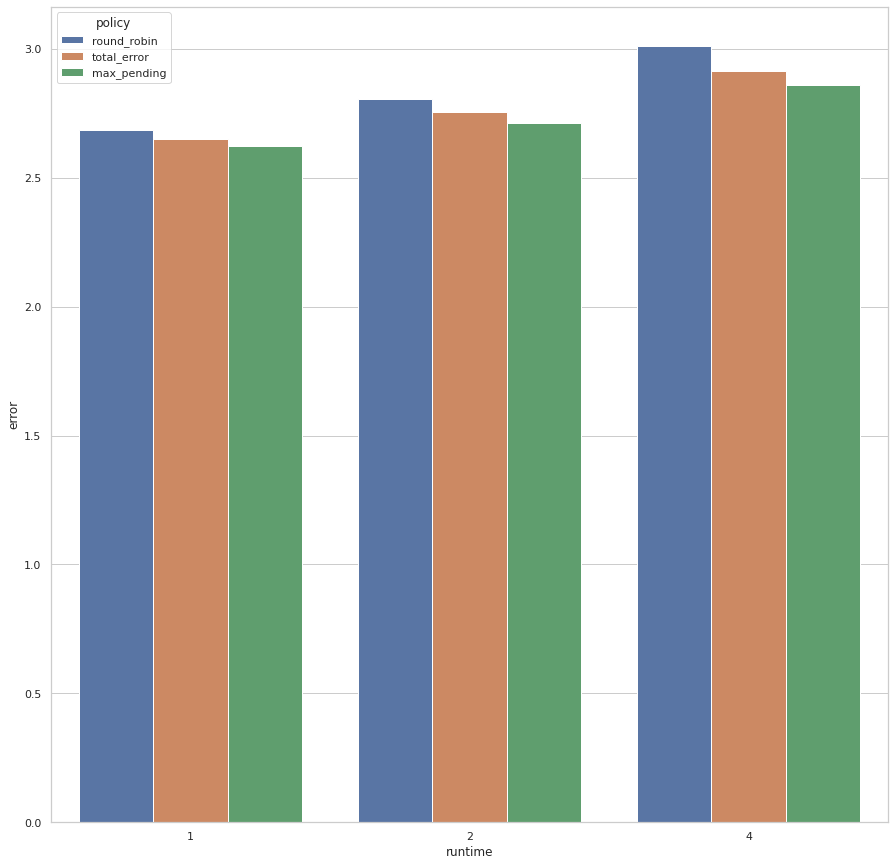

In [219]:
ax = sns.barplot(x="runtime", y="error", hue="policy", data=results_df)

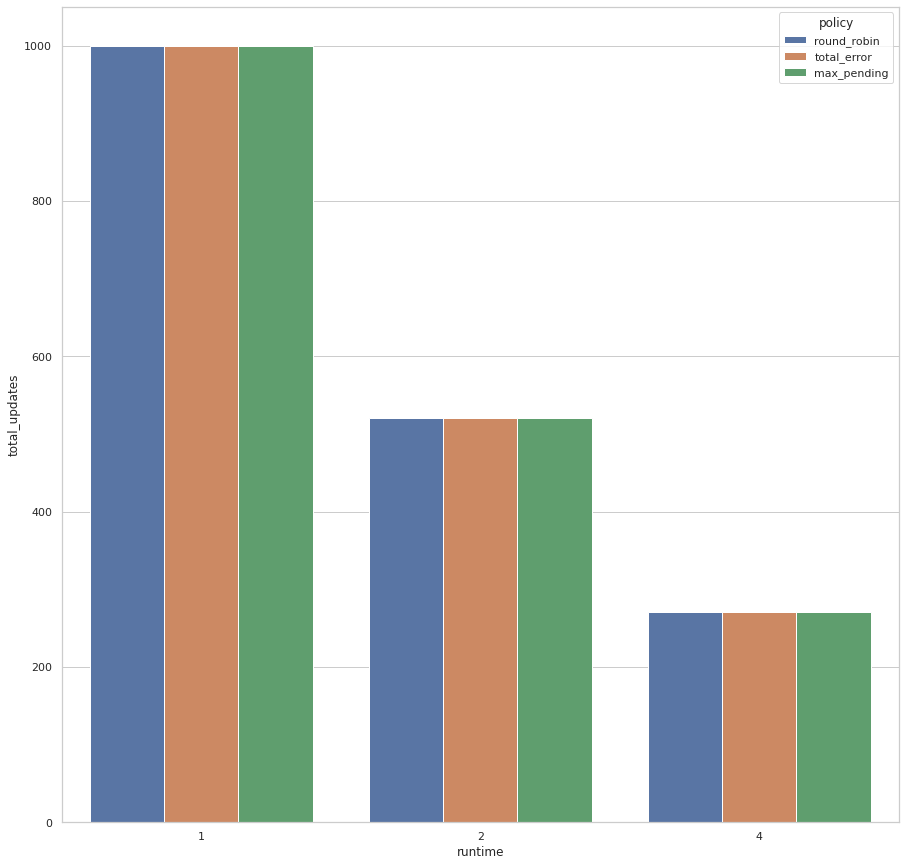

In [220]:
ax = sns.barplot(x="runtime", y="total_updates", hue="policy", data=results_df)

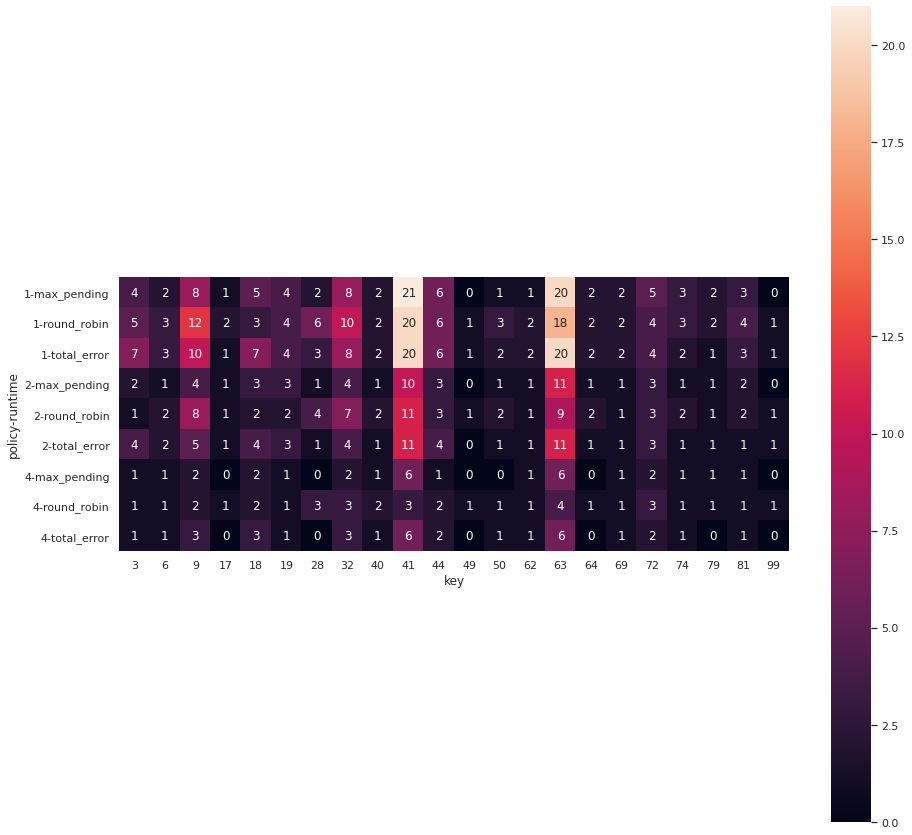

In [223]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
d = updates_df[updates_df["key"] < 100].groupby(["key", "policy", "runtime"]).size().unstack("key", fill_value=0)
ax = sns.heatmap(d, square=True, annot=True)

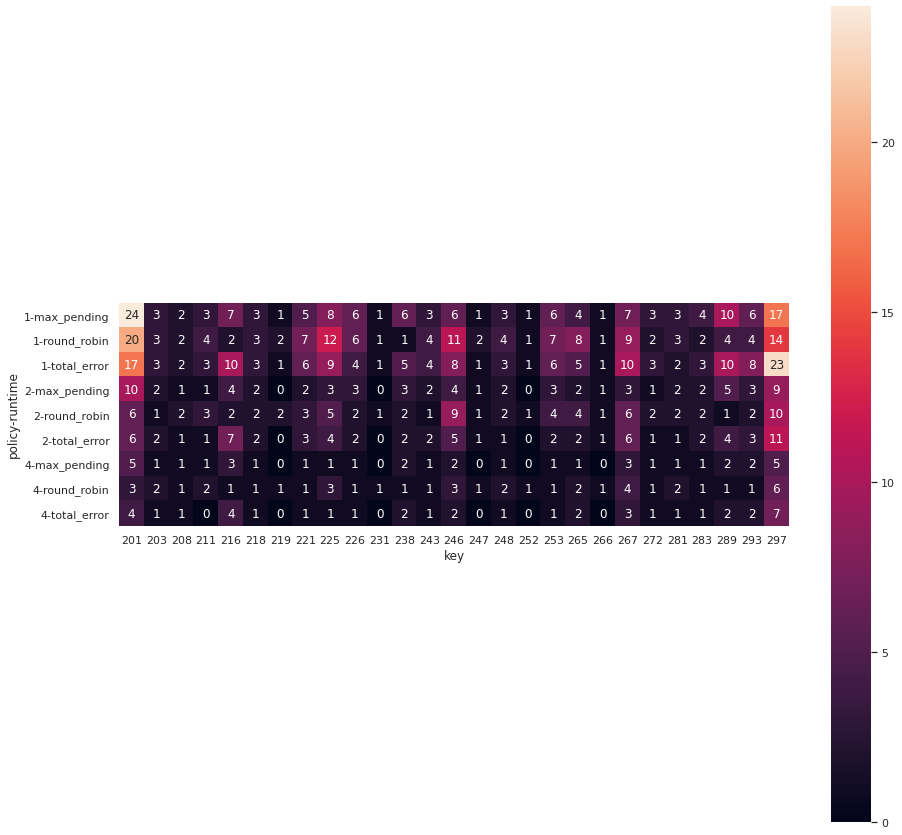

In [224]:
d = updates_df[(updates_df["key"] > 200) & (updates_df["key"] < 300)].groupby(["key", "policy", "runtime"]).size().unstack("key", fill_value=0)
ax = sns.heatmap(d, square=True, annot=True)

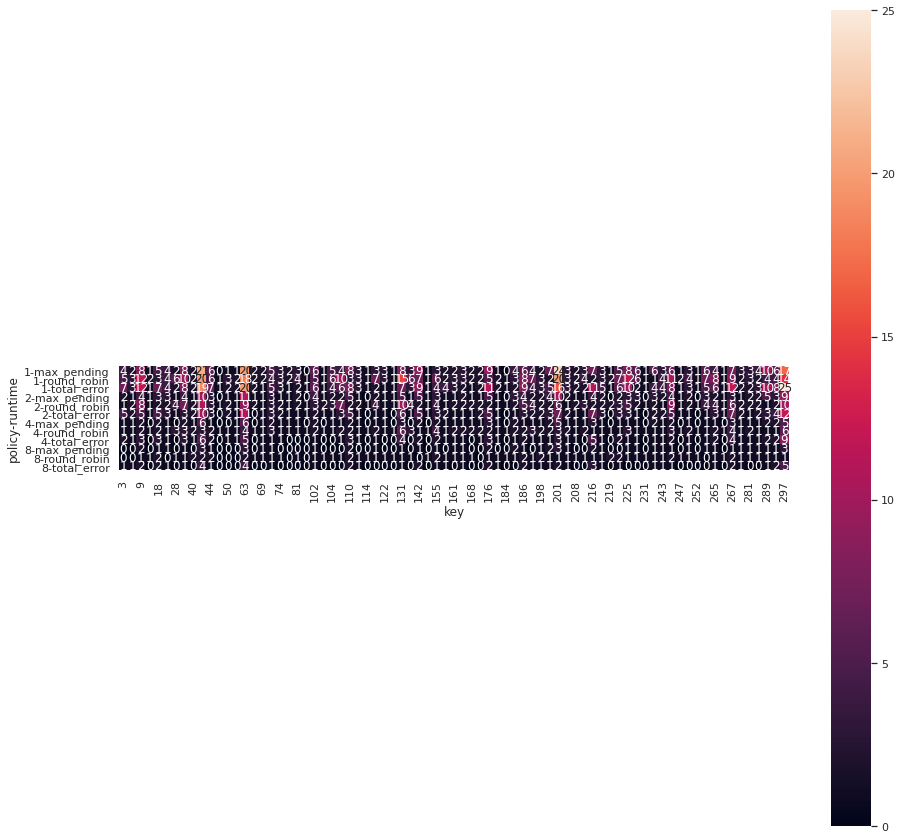

In [207]:
ax = sns.heatmap(d, square=True, annot=True)

In [ ]:
# giant queue of both movies and users 
# add error to both movies and users 
# compute mean of the ratings for the user -> set it as the bias 